#**Model Evaluation**
Instructor: Dr Mario Rosario Guarracino


---

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# % cd "/content/drive/My Drive/2020 09 Cambridge course/PyNotebooks/"

**Import libraries**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import make_column_transformer

# Classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE

# Classifier metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix

import seaborn as sns

**Load data**

In [ ]:
cleveland_heart = pd.read_csv("data/heart_processed.csv")
X = cleveland_heart.iloc[:,:-1].values
y = cleveland_heart.iloc[:,-1].values
cleveland_heart.head()

In [ ]:
numerical_vars = ['age', 'chol', 'trestbps', 'thalach', 'oldpeak']
numerical_vars_idx = cleveland_heart.columns.get_indexer(numerical_vars)
cat_vars = ['cp', 'restecg', 'slope', 'thal']
cat_vars_idx = cleveland_heart.columns.get_indexer(cat_vars)
rest_vars = ['sex', 'fbs', 'exang', 'ca']
print(cat_vars_idx)
print(numerical_vars_idx)

**Transform the data and Split into train and test**

In [ ]:
# One hot encoder of categorical features
encoder = OneHotEncoder()
X_enc = encoder.fit_transform(cleveland_heart.iloc[:, cat_vars_idx])
feature_names_enc=encoder.get_feature_names()

# rename part of feature names assigned to vaariables by one hot encoders
cat_vars = ['cp', 'restecg', 'slope', 'thal']
replace_cat = {'x0': 'cp',
 'x1': 'restecg',
 'x2': 'slope',
 'x3': 'thal',
}
print(feature_names_enc)
feature_names_enc = pd.Series(feature_names_enc).str.rsplit('_').str[0].map(replace_cat) + '_' + pd.Series(feature_names_enc).str.rsplit('_').str[-1]
print(feature_names_enc.to_list())

# convert sparse one hot encoded array to dataframe
df_enc = pd.DataFrame(data=X_enc.toarray(),  columns=feature_names_enc)

# concatenate the encoded categorical features with the rest of the features
cleveland_heart_enc = pd.concat([cleveland_heart[numerical_vars + rest_vars], df_enc], axis=1)

X = cleveland_heart_enc.iloc[:,:-1].values
y = cleveland_heart.iloc[:,-1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, shuffle=True)

# Standard scaling of the numerical feature columns
trans = make_column_transformer(
    (StandardScaler(), numerical_vars_idx), remainder='passthrough'
)

trans.fit(X_train)
X_train_transformed = trans.transform(X_train)
X_test_transformed = trans.transform(X_test)
cleveland_heart_enc.head()



---


#### **Decision Trees**


In [ ]:
model = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=None, min_samples_split=2, random_state=1)
model.fit(X_train_transformed, y_train)

y_predicted = model.predict(X_test_transformed)

#print('Confusion Matrix:',  '\n', confusion_matrix(y_test, y_predicted), '\n')
print(classification_report(y_test, y_predicted), '\n')
plot_confusion_matrix(model, X_test_transformed, y_test, cmap=plt.cm.Blues)

In [ ]:
feature_names_for_tree = cleveland_heart_enc.columns.values.tolist()[:-1]
## text representation of tree
# text_representation = tree.export_text(model, max_depth=3, feature_names=feature_names_for_tree)
# print(text_representation)

## plot with sklearn.tree
# tree.plot_tree(model, max_depth=3, filled=True)

## plot with graphviz
from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(model, out_file=dot_data, feature_names=feature_names_for_tree,
                filled=True, rounded=True, class_names = np.array(['0', '1']),
                special_characters=True, max_depth=3)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

**Change max depth**

In [ ]:
model = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=4, min_samples_split=2, random_state=1)
model.fit(X_train_transformed, y_train)

y_predicted = model.predict(X_test_transformed)

#print('Confusion Matrix:',  '\n', confusion_matrix(y_test, y_predicted), '\n')
print(classification_report(y_test, y_predicted), '\n')
plot_confusion_matrix(model, X_test_transformed, y_test, cmap=plt.cm.Blues)

**Feature Importance**

In [ ]:
features_imp = np.array(model.feature_importances_)
# print(features_imp)
sort_index = np.argsort(features_imp)[::-1]
# print(sort_index)
print("original_feature_order:", feature_names_for_tree)
print()
print("Ranked_order_ascending:", [feature_names_for_tree[i] for i in sort_index])



---


#### **Random Forest Classifier** 

In [ ]:
model = RandomForestClassifier(n_estimators = 20, random_state=1)
model.fit(X_train_transformed, y_train)
y_predicted = model.predict(X_test_transformed)

print('Accuracy:', accuracy_score(y_test, y_predicted), '\n')
# print('Confusion Matrix:',  '\n', confusion_matrix(y_test, y_predicted), '\n')
print('Classification Report:',  '\n', classification_report(y_test, y_predicted), '\n')
plot_confusion_matrix(model, X_test_transformed, y_test, cmap=plt.cm.Blues)

**Feature Importance**

In [ ]:
model.feature_importances_
# Task: Get the ranked list of features as done for the Decision Tree



---


#### **Support Vector Machine (SVM)** 
with Grid search

In [ ]:
model = SVC(kernel = 'linear', C =1)
model.fit(X_train_transformed, y_train)
y_predicted = model.predict(X_test_transformed)

print('Accuracy:', accuracy_score(y_test, y_predicted), '\n')
# print('Confusion Matrix:',  '\n', confusion_matrix(y_test, y_predicted), '\n')
print('Classification Report:',  '\n', classification_report(y_test, y_predicted), '\n')
plot_confusion_matrix(model, X_test_transformed, y_test, cmap=plt.cm.Blues)

 **Grid search for parameter tuning**

In [ ]:
#SVM -  grid search for parameters
svm = SVC()
parameters = {'kernel':('linear', 'rbf'), 'C':(1, 1.25, 2),'gamma': (0.01, 0.05, 0.1, 1)}
model = GridSearchCV(svm, parameters, scoring="f1")
model.fit(X_train_transformed, y_train)
y_predicted = model.predict(X_test_transformed)

print("Accuracy Train:"+str(np.average(cross_val_score(model, X_train_transformed, y_train, scoring='accuracy'))))
print("\nBest parameters :")
print()
print(model.best_params_)

print('\nAccuracy Test:', accuracy_score(y_test, y_predicted), '\n')
print('Classification Report:',  '\n', classification_report(y_test, y_predicted), '\n')



---


#### **Regec**

In [ ]:
X = cleveland_heart.iloc[:,:-1].values
y = cleveland_heart.iloc[:,-1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, shuffle=True)

trans = make_column_transformer(
    (StandardScaler(), numerical_vars_idx),
    (OneHotEncoder(), cat_vars_idx), remainder='passthrough'
)

trans.fit(X_train)
X_train_transformed = trans.transform(X_train)
X_test_transformed = trans.transform(X_test)

# Import local file regec2.py containing the regec classifier
import regec2 as r

[y_predicted, accuracy_regec, Z, W] = r.regec(X_train_transformed, y_train*2-1, X_test_transformed, y_test*2-1, 150, 0.001, 0.001)
print('\nAccuracy:', accuracy_regec, '\n')
print('Classification Report:',  '\n', classification_report(y_test*2-1, y_predicted), '\n')



---


###**Evaluating classifiers**

**Initialize classifers**

In [ ]:
names = ["KNN", "LogReg", "DT", "RF", "SVM", "GNB", "LDA"]
models = [KNeighborsClassifier(n_neighbors = 5),
          LogisticRegression(random_state=1), 
          DecisionTreeClassifier(criterion='entropy',max_depth=4,random_state=1), 
          RandomForestClassifier(n_estimators = 20, random_state=1), 
          SVC(kernel='rbf', gamma=0.05, random_state=1),
          GaussianNB(),
          LinearDiscriminantAnalysis(),]



---


#### **Train/Test split**


In [ ]:
trans = make_column_transformer(
    (StandardScaler(), numerical_vars_idx),
    (OneHotEncoder(), cat_vars_idx), remainder='passthrough'
)

X = cleveland_heart.iloc[:,:-1].values
y = cleveland_heart.iloc[:,-1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, shuffle=True)

acc_scores = []
for model, name in zip(models, names):
    # With pipeline multiple steps can be performed at the same time
    model_run = Pipeline([('transformer', trans), (name, model)])
    model_run.fit(X_train, y_train)
    y_predicted = model_run.predict(X_test)
    acc_scores.append(accuracy_score(y_test, y_predicted))

scores_df = pd.DataFrame({'Model': names, 'Accuracy': acc_scores})
# add regec results to the dataframe
scores_df.loc[scores_df.index.max() + 1] = ['Regec'] + [accuracy_regec]

scores_df

In [ ]:
ax = sns.barplot(data=scores_df, x='Model', y='Accuracy', hue='Model', dodge=False, palette=sns.color_palette("Set3"))
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.title('Classifier Accuracy')


#### **Cross-validation**
https://scikit-learn.org/stable/modules/cross_validation.html. The cross-validation measures can be imported from sklearn.model_selection. The following figures are taken from https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html

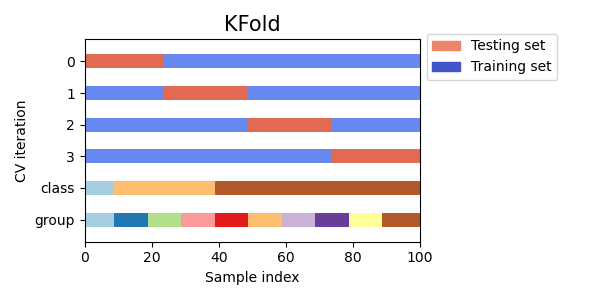

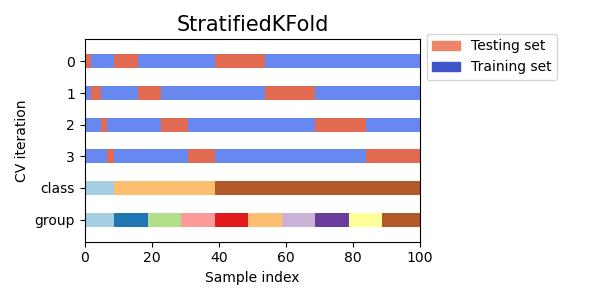



---


**K-Fold (stratified cross validation)**

In [ ]:
trans = make_column_transformer(
    (StandardScaler(), numerical_vars_idx),
    (OneHotEncoder(), cat_vars_idx), remainder='passthrough'
)

X = cleveland_heart.iloc[:,:-1].values
y = cleveland_heart.iloc[:,-1].values

acc_scores = []
avg_acc_scores = []
std_scores = []
X = cleveland_heart.iloc[:,:-1].values
y = cleveland_heart.iloc[:,-1].values
# model evaluation
for model, name in zip(models, names):
  model_run = Pipeline([('transformer', trans), (name, model)])

  cv = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
  
  scores = cross_val_score(model_run, X, y, scoring='accuracy', cv=cv)
  acc_scores.append(scores)
  avg_acc_scores.append(scores.mean())
  std_scores.append(scores.std())
scores_df_cv = pd.DataFrame({'Classifier': names, 'Average Accuracy': avg_acc_scores, 'SD': std_scores})
scores_df_cv

In [ ]:
ax = sns.barplot(data=scores_df_cv, x='Classifier', y='Average Accuracy', hue='Classifier', dodge=False, palette=sns.color_palette("Set3"))
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.title('Classifier Accuracy (Stratified 10 fold cross-validation)')

In [ ]:
# Compare Classifiers
model_scores_df = pd.DataFrame(acc_scores).T
model_scores_df.columns = names
print(model_scores_df.head(), '\n')

df = model_scores_df.apply(pd.to_numeric).melt(var_name='Classifier', value_name='Accuracy')
ax = sns.boxplot(data=df, x='Classifier', y='Accuracy', palette=sns.color_palette("Set3"))
ax = sns.swarmplot(data=df, x='Classifier', y='Accuracy', color='black')
plt.title('Classifier Accuracy (Stratified 10 fold cross-validation)')

### **Recursive feature elimination (RFE)**

In [ ]:
trans = make_column_transformer(
    (StandardScaler(), numerical_vars_idx),
    (OneHotEncoder(), cat_vars_idx), remainder='passthrough'
)

X = cleveland_heart.iloc[:,:-1].values
y = cleveland_heart.iloc[:,-1].values

acc_scores = []
avg_acc_scores = []
std_scores = []
# model evaluation
for model, name in zip(models, names):
  estimator_for_rfe = SVC(kernel='linear', random_state=1)
  rfe = RFE(estimator_for_rfe, n_features_to_select=10)
  model_run = Pipeline([('transformer', trans), ('RFE', rfe), (name, model)])

  # evaluate model
  cv = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
  scores = cross_val_score(model_run, X, y, scoring='accuracy', cv=cv)
  avg_acc_scores.append(scores.mean())
  std_scores.append(scores.std())

scores_df_cv_rfe = pd.DataFrame({'Classifier': names, 'Average Accuracy': avg_acc_scores, 'SD': std_scores})
scores_df_cv_rfe

In [ ]:
scores_df_cv.insert(3, 'Average Accuracy: After RFE', scores_df_cv_rfe['Average Accuracy'].tolist(), allow_duplicates=True)
scores_df_cv.drop('SD', axis=1, inplace=True)
scores_df_cv

In [ ]:
df = pd.melt(scores_df_cv, id_vars="Classifier", var_name="Acc", value_name="Average Accuracy")
sns.catplot(x='Classifier', y='Average Accuracy', hue='Acc', data=df, kind='bar', dodge=True, palette=sns.color_palette("icefire"), alpha = 0.8, legend=False, aspect=1.3)
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0, fontsize=12)



---

